<a href="https://colab.research.google.com/github/Peksyaji/Kaggle/blob/main/Prediksi_Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Informasi atribut pada data

1. id: nomor id
2. gender: "Male", "Female" atau "Other"
3. age: umur pasien
4. hypertension: 0 jika pasien tidak hipertensi, 1 jika pasien hipertensi
5. heart_disease: 0 jika pasien tidak memiliki penyakit jantung, 1 jika pasien memiliki penyakit jantung
6. ever_married: "No" atau "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" atau "Self-employed"
8. Residence_type: "Rural" atau "Urban"
9. avg_glucose_level: kadar glukosa rata-rata dalam darah
10. bmi: indeks massa tubuh
11. smoking_status: "formerly smoked", "never smoked", "smokes" atau "Unknown"*
12. stroke: 1 jika pasien mengalami stroke atau 0 jika tidak

Note: "Unknown" pada smoking_status berarti informasi tidak tersedia untuk pasien ini

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import copy
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from numpy import mean
from numpy import std
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/panaguiton-markangelo-github/strokeprediction/master/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Data memiliki miisng value pada variabel 'bmi' yang mencapai hampir 5% dari keseluruhan data. Nilai ini bisa dikatakan cukup banyak sehingga diperlukan penanganan missing value.

Akan digunakan 2 metode penanganan missing value, yaitu imputasi sederhana dan imputasi dengan KNNImputer

# Praproses dan Eksplorasi

In [4]:
# Menghapus kolom yang tidak diperlukan
df.drop('id', axis=1, inplace=True)

In [5]:
# Cek duplikasi data
df.duplicated().sum()

0

Tidak ditemukan data yang terduplikasi

In [6]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

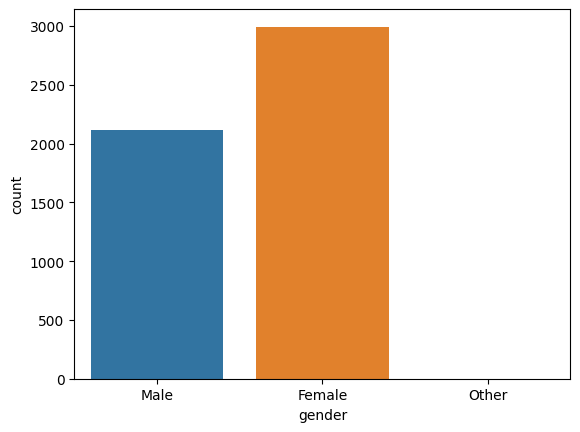

In [7]:
sns.countplot(df, x='gender')
plt.show()

Karena jenis kelamin yang bernilai 'Other' hanya 1 observasi, maka observasi tersebut diubah menjadi nilai modus, yakni 'Female'

In [8]:
# Mengubah 'Other' menjadi 'Female'
for i in range(len(df['gender'])):
  if df['gender'][i] == 'Other':
    df['gender'][i] = 'Female'

<ipython-input-8-cf2294aef702>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'][i] = 'Female'


In [9]:
df['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

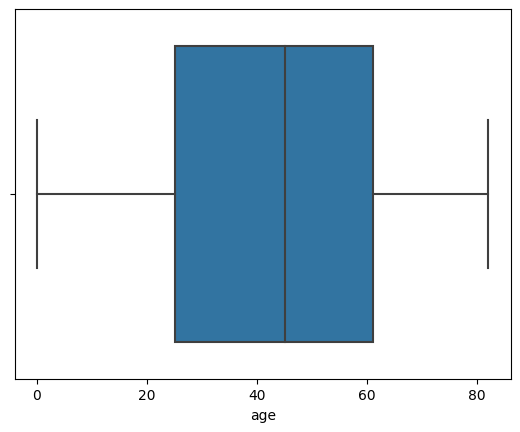

In [10]:
sns.boxplot(x=df['age'])
plt.show()

In [11]:
df['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [12]:
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

Hanya sedikit  observasi yang memiliki penyakit tekanan darah tinggi dan penyakit jantung

In [13]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [14]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [15]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

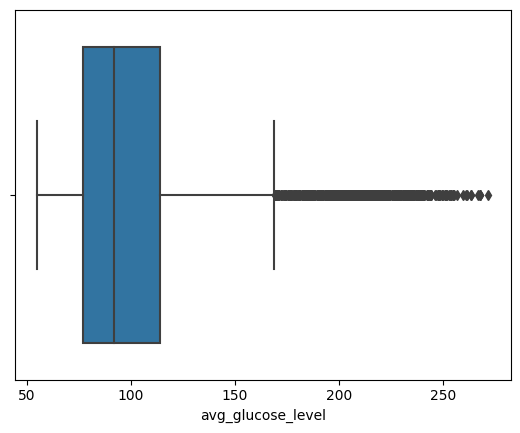

In [16]:
sns.boxplot(df, x='avg_glucose_level')
plt.show()

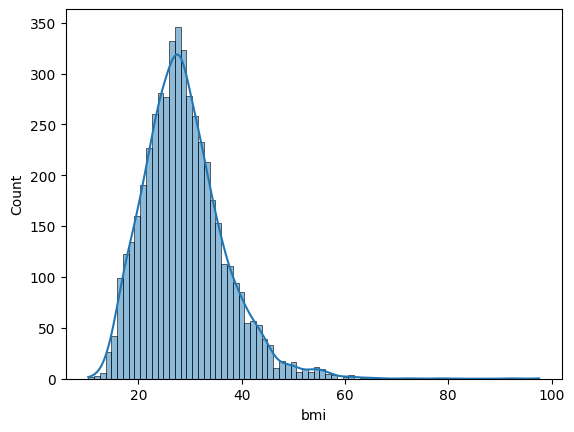

In [17]:
sns.histplot(x=df['bmi'], kde=True)
plt.show()

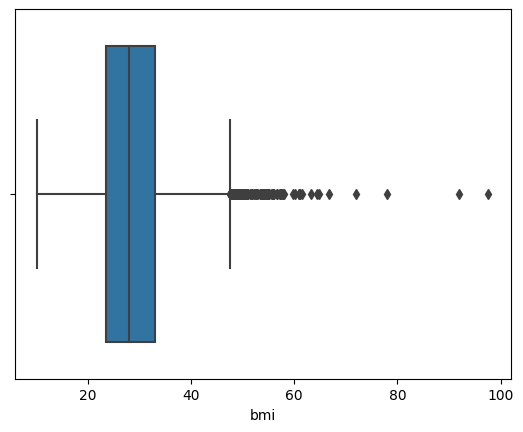

In [18]:
sns.boxplot(x=df['bmi'])
plt.show()

Rata-rata level glukosa dan indeks massa tubuh memiliki cukup banyak outlier, hal ini membuat dibutuhkannya model yang robust terhadap outlier

In [19]:
# Uji normalitas
k2, p = stats.normaltest(df['bmi'], nan_policy='omit')
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # hipotesis nol: x berasal dari distribusi normal
    print('Data tidak berdistribusi normal')
else:
    print('Data berdistribusi normal')

p = 1.79344e-222
Data tidak berdistribusi normal


In [20]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [21]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [22]:
# Encoding
df['gender'] = df['gender'].map({
    'Male':0,
    'Female':1
})

df['ever_married'] = df['ever_married'].map({
    'Yes':0,
    'No':1
})

df['work_type'] = df['work_type'].map({
    'Private':0,
    'Self-employed':1,
    'children':2,
    'Govt_job':3,
    'Never_worked':4
})

df['Residence_type'] = df['Residence_type'].map({
    'Urban':0,
    'Rural':1
})

df['smoking_status'] = df['smoking_status'].map({
    'never smoked':0,
    'Unknown':1,
    'formerly smoked':2,
    'smokes':3
})

# Imputasi dengan median

In [23]:
df1 = copy(df)

In [24]:
# Mengisi missing value dengan nilai median
df1['bmi'].fillna(df1['bmi'].median(), inplace=True)

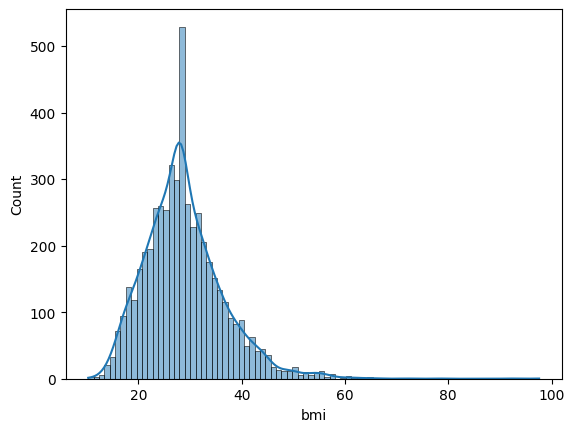

In [25]:
sns.histplot(x=df1['bmi'], kde=True)
plt.show()

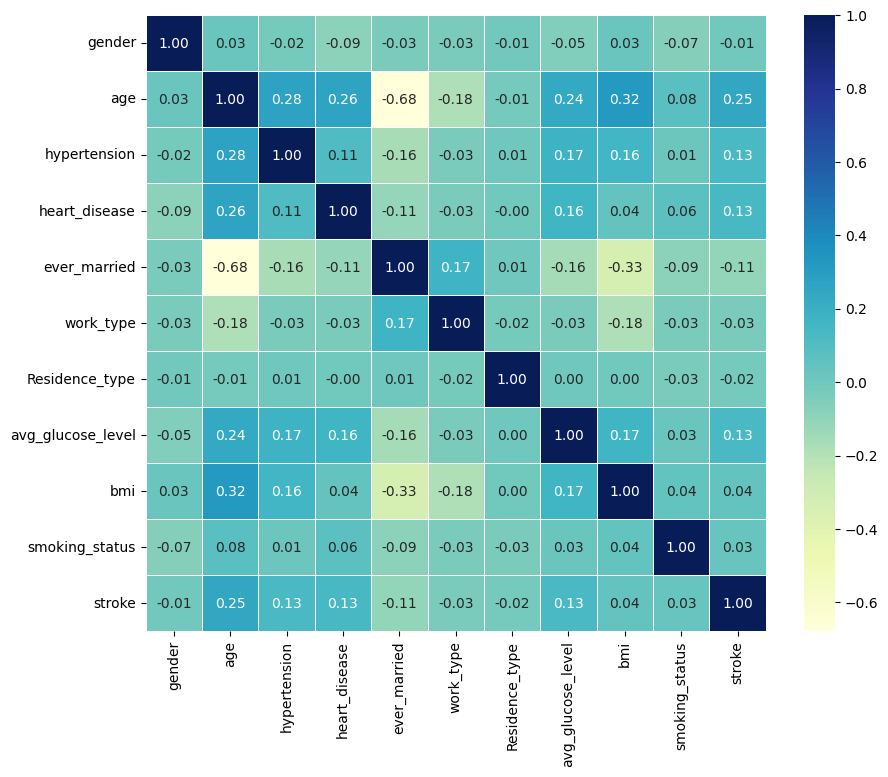

In [26]:
# Matriks korelasi
corr_matrix = df1.corr() 
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr_matrix,
            annot=True, 
            linewidths=0.5,
            fmt=".2f", 
            cmap="YlGnBu" 
        )
plt.show()

In [27]:
# Memisahkan variabel penjelas dengan variabel target
X = df1.drop('stroke', axis=1)
y = df1['stroke']

# Resampling
smote = SMOTE()

x_smote, y_smote = smote.fit_resample(X, y)

print('Ukuran dataset asli: ', y.value_counts())
print('Ukuran dataset setelah resampling: ', y_smote.value_counts())

Ukuran dataset asli:  0    4861
1     249
Name: stroke, dtype: int64
Ukuran dataset setelah resampling:  1    4861
0    4861
Name: stroke, dtype: int64


In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = 42)

In [29]:
models = {"Logistic Regression": LogisticRegression(random_state=42),
          "SVM": svm.LinearSVC(random_state=42),
          "KNeighbors": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(random_state=42),
          "AdaBoost": AdaBoostClassifier(random_state=42)
         }

In [30]:
# Validasi silang model
for name, model in models.items():
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    print(name, '\n5-Fold Validation Scores:\n', scores)
    print('Cross Validation Training Accuracy: %.3f (%.3f)\n' % (mean(scores), std(scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression 
5-Fold Validation Scores:
 [0.81812339 0.8251928  0.80707395 0.8096463  0.81607717]
Cross Validation Training Accuracy: 0.815 (0.006)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM 
5-Fold Validation Scores:
 [0.50128535 0.73136247 0.49967846 0.73311897 0.49967846]
Cross Validation Training Accuracy: 0.593 (0.114)

KNeighbors 
5-Fold Validation Scores:
 [0.87982005 0.88624679 0.88167203 0.86945338 0.89517685]
Cross Validation Training Accuracy: 0.882 (0.008)

Random Forest 
5-Fold Validation Scores:
 [0.93123393 0.94087404 0.92540193 0.93054662 0.94405145]
Cross Validation Training Accuracy: 0.934 (0.007)

AdaBoost 
5-Fold Validation Scores:
 [0.84897172 0.85218509 0.83215434 0.83279743 0.84437299]
Cross Validation Training Accuracy: 0.842 (0.008)



Model Random Forest memiliki rata-rata akurasi validasi silang tertinggi dan standar deviasi terendah kedua.

In [31]:
# Metrik evaluasi
results = dict()
for name, model in models.items():
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print('\nAlgorithm: ', name)
    res_cm = confusion_matrix(y_test, predicted)
    print('Confusion Matrix:\n', res_cm)
    res_acc = accuracy_score(y_test, predicted)
    print('Accuracy: ', res_acc)
    res_pres = precision_score(y_test, predicted, average='micro')
    print('Precision: ', res_pres)
    res_recall = recall_score(y_test, predicted, average='micro')
    print('Recall Score: ', res_recall)
    res_f1 = f1_score(y_test, predicted, average='micro')
    print('F1 Score: ', res_f1)
    
    results[name]=res_acc


Algorithm:  Logistic Regression
Confusion Matrix:
 [[737 238]
 [164 806]]
Accuracy:  0.7933161953727507
Precision:  0.7933161953727507
Recall Score:  0.7933161953727507
F1 Score:  0.7933161953727506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Algorithm:  SVM
Confusion Matrix:
 [[598 377]
 [ 67 903]]
Accuracy:  0.7717223650385604
Precision:  0.7717223650385604
Recall Score:  0.7717223650385604
F1 Score:  0.7717223650385604

Algorithm:  KNeighbors
Confusion Matrix:
 [[775 200]
 [ 21 949]]
Accuracy:  0.8863753213367609
Precision:  0.8863753213367609
Recall Score:  0.8863753213367609
F1 Score:  0.8863753213367609

Algorithm:  Random Forest
Confusion Matrix:
 [[911  64]
 [ 51 919]]
Accuracy:  0.9408740359897172
Precision:  0.9408740359897172
Recall Score:  0.9408740359897172
F1 Score:  0.9408740359897172

Algorithm:  AdaBoost
Confusion Matrix:
 [[778 197]
 [128 842]]
Accuracy:  0.8329048843187661
Precision:  0.8329048843187661
Recall Score:  0.8329048843187661
F1 Score:  0.8329048843187661


Model Random Forest meripakan model terbaik ditijau dari semua metrik evaluasi yang digunakan

In [32]:
# hyperparameters tuning
parameter = {'criterion':['gini', 'entropy', 'log_loss'],
             'max_features':['sqrt', 'log2', None],
             'bootstrap':[True, False]
             }

grid = GridSearchCV(RandomForestClassifier(random_state=42), parameter)
model = grid.fit(x_smote, y_smote)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt'} 

RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42) 



In [33]:
rfc = RandomForestClassifier(bootstrap=False, criterion='entropy', random_state=42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

cm = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', cm)
print(classification_report(y_test, pred))

Confusion Matrix:
 [[929  46]
 [ 47 923]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       975
           1       0.95      0.95      0.95       970

    accuracy                           0.95      1945
   macro avg       0.95      0.95      0.95      1945
weighted avg       0.95      0.95      0.95      1945



# Imputasi dengan KNN

In [34]:
from sklearn.impute import KNNImputer

In [35]:
imputer = KNNImputer(n_neighbors=3)
imput = imputer.fit_transform(df.drop('stroke',axis=1))
df_imput = pd.DataFrame(imput, columns=df.drop('stroke',axis=1).columns)
df2 = pd.concat([df_imput, df['stroke']], axis=1)

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   float64
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   float64
 3   heart_disease      5110 non-null   float64
 4   ever_married       5110 non-null   float64
 5   work_type          5110 non-null   float64
 6   Residence_type     5110 non-null   float64
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   float64
 10  stroke             5110 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 439.3 KB


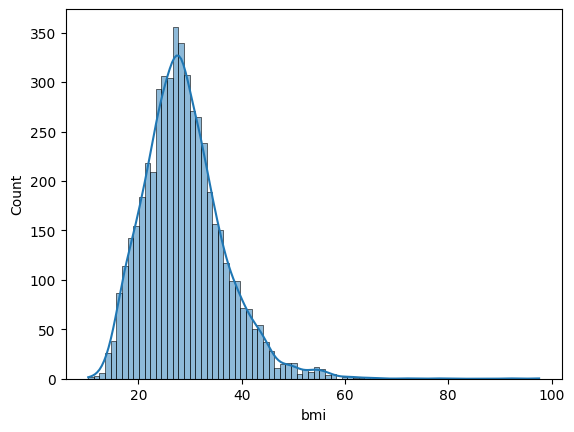

In [37]:
sns.histplot(x=df2['bmi'], kde=True)
plt.show()

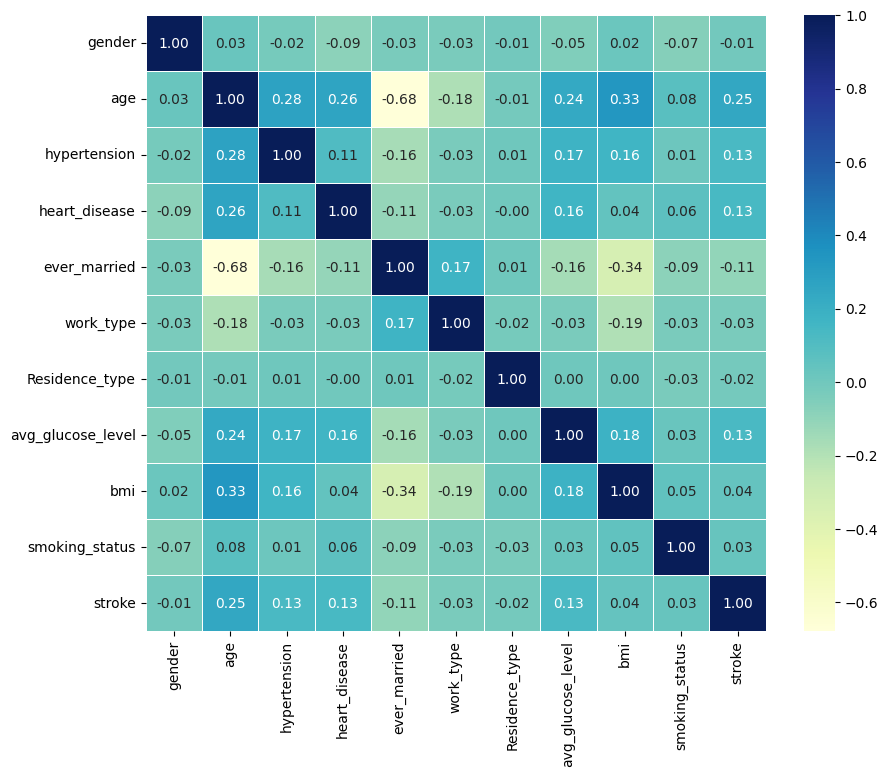

In [38]:
# Matriks korelasi
corr_matrix = df2.corr() 
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr_matrix,
            annot=True, 
            linewidths=0.5,
            fmt=".2f", 
            cmap="YlGnBu" 
        )
plt.show()

In [39]:
# Memisahkan variabel penjelas dnegan variabel target
X = df2.drop('stroke', axis=1)
y = df2['stroke']

# Resampling
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

print('Ukuran dataset asli: ', y.value_counts())
print('Ukuran dataset setelah resampling: ', y_smote.value_counts())

Ukuran dataset asli:  0    4861
1     249
Name: stroke, dtype: int64
Ukuran dataset setelah resampling:  1    4861
0    4861
Name: stroke, dtype: int64


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42)

In [41]:
# Validasi silang
for name, model in models.items():
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    print(name, '\n5-Fold Validation Scores:\n', scores)
    print('Cross Validation Training Accuracy: %.3f (%.3f)\n' % (mean(scores), std(scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression 
5-Fold Validation Scores:
 [0.77827763 0.75642674 0.77363344 0.77684887 0.77877814]
Cross Validation Training Accuracy: 0.773 (0.008)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM 
5-Fold Validation Scores:
 [0.75706941 0.69473008 0.50353698 0.50418006 0.61672026]
Cross Validation Training Accuracy: 0.615 (0.101)

KNeighbors 
5-Fold Validation Scores:
 [0.8811054  0.89010283 0.88102894 0.87138264 0.89646302]
Cross Validation Training Accuracy: 0.884 (0.009)

Random Forest 
5-Fold Validation Scores:
 [0.96658098 0.96979434 0.96784566 0.97427653 0.97234727]
Cross Validation Training Accuracy: 0.970 (0.003)

AdaBoost 
5-Fold Validation Scores:
 [0.95179949 0.96079692 0.94340836 0.95884244 0.94662379]
Cross Validation Training Accuracy: 0.952 (0.007)



Random FOrest tetap menjadi model dengan rata-rata akurasi validasi silang tertinggi bahkan sekarang mendapatkan standar deviasi terendah. Model selanjutnya yang performanya mendekati adalah AdaBoost.

In [42]:
# Metrik evaluasi
results = dict()
for name, model in models.items():
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print('\nAlgorithm: ', name)
    res_cm = confusion_matrix(y_test, predicted)
    print('Confusion Matrix:\n', res_cm)
    res_acc = accuracy_score(y_test, predicted)
    print('Accuracy: ', res_acc)
    res_pres = precision_score(y_test, predicted, average='micro')
    print('Precision: ', res_pres)
    res_recall = recall_score(y_test, predicted, average='micro')
    print('Recall Score: ', res_recall)
    res_f1 = f1_score(y_test, predicted, average='micro')
    print('F1 Score: ', res_f1)
    
    results[name]=res_acc


Algorithm:  Logistic Regression
Confusion Matrix:
 [[724 251]
 [179 791]]
Accuracy:  0.7789203084832905
Precision:  0.7789203084832905
Recall Score:  0.7789203084832905
F1 Score:  0.7789203084832905


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Algorithm:  SVM
Confusion Matrix:
 [[576 399]
 [ 40 930]]
Accuracy:  0.774293059125964
Precision:  0.774293059125964
Recall Score:  0.774293059125964
F1 Score:  0.774293059125964

Algorithm:  KNeighbors
Confusion Matrix:
 [[785 190]
 [ 16 954]]
Accuracy:  0.8940874035989718
Precision:  0.8940874035989718
Recall Score:  0.8940874035989718
F1 Score:  0.8940874035989718

Algorithm:  Random Forest
Confusion Matrix:
 [[968   7]
 [ 52 918]]
Accuracy:  0.9696658097686375
Precision:  0.9696658097686375
Recall Score:  0.9696658097686375
F1 Score:  0.9696658097686375

Algorithm:  AdaBoost
Confusion Matrix:
 [[957  18]
 [ 74 896]]
Accuracy:  0.9526992287917738
Precision:  0.9526992287917738
Recall Score:  0.9526992287917738
F1 Score:  0.9526992287917738


Random Forest memiliki metrik evaluasi terbaik dari semua model yang diuji

In [43]:
# Hyperparameters tuning
parameter = {'criterion':['gini', 'entropy', 'log_loss'],
             'max_features':['sqrt', 'log2', None],
             'bootstrap':[True, False]
             }

grid = GridSearchCV(RandomForestClassifier(random_state=42), parameter)
model = grid.fit(X_smote, y_smote)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt'} 

RandomForestClassifier(random_state=42) 



In [44]:
rfc = RandomForestClassifier(criterion='entropy', random_state=42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

cm = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', cm)
print(classification_report(y_test, pred))

Confusion Matrix:
 [[966   9]
 [ 53 917]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       975
           1       0.99      0.95      0.97       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



In [45]:
# Hyperparameters tuning
parameter = {'n_estimators':[50, 100],
             'learning_rate':[0, 1, 10],
             'algorithm':['SAMME', 'SAMME.R']
             }

grid = GridSearchCV(AdaBoostClassifier(random_state=42), parameter)
model = grid.fit(X_smote, y_smote)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 124, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/skle

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100} 

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42) 



In [46]:
abc = AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
abc.fit(X_train, y_train)
pred = abc.predict(X_test)

cm = confusion_matrix(y_test, pred)
print('Confusion Matrix:\n', cm)
print(classification_report(y_test, pred))

Confusion Matrix:
 [[973   2]
 [ 69 901]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       975
           1       1.00      0.93      0.96       970

    accuracy                           0.96      1945
   macro avg       0.97      0.96      0.96      1945
weighted avg       0.97      0.96      0.96      1945



# Kesimpulan:
* Penanganan missing value dengan KNNImputer lebih baik daripada dengan pengisian nilai median
* Random Forest selalu menjadi model yang robust dengan apapun metode pengisian missing value yang digunakan
* Random Forest dengan pengisian missing value menggunakan KNNImputer memiliki akurasi mencapai 97%